<h1>Project 4: SafeComm Digital Security Solutions</h1>
<p>Team Captain: E00020</p>
<p>Member 2: E00491</p>
<p>Member 3: E00045</p>
</br></br>
<h2>Table of Contents</h2>
<ol>
  <li><a href="#section1">Setup</a></li>
  <li><a href="#section2">EDA</a></li>
  <li><a href="#section3">Data Preprocessing</a></li>
  <li><a href="#section4">Model Training and Testing</a></li>
  <li><a href="#section5">Comparing Testing Results</a></li>
</ol>
</br></br>

<h2 id="section1">Setup</h2>

<h3>Importing all Libaries</h3>

In [117]:
# importing all necessary libaries => delete un-used!
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from scipy.sparse import csr_matrix
import spacy
import re
import string
import unicodedata
from bs4 import BeautifulSoup
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import normalize
from sklearn.preprocessing import OneHotEncoder
import keras
from keras.models import Sequential
from keras.layers import Dense
from textblob import TextBlob
from textblob import Word
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

import warnings
warnings.filterwarnings('ignore')


<h3>Importing the Data</h3>

In [118]:
# importing the csv into a pandas data frame
df = pd.read_csv("./sms.csv")
print("Shape: ", df.shape)
print("Head: ", df.head(1))


Shape:  (5572, 4)
Head:     Fraudolent                                           SMS_test       ID  \
0           0  Squeeeeeze!! This is christmas hug.. If u lik ...  1EWYRBL   

  Date and Time  
0    2017-12-02  


<h3>Inspecting the Data</h3>

In [119]:
# checking the distribution of each variable type
variable_types = df.dtypes
print("Variable Types")
print(variable_types)

# checking for missing values in the dataset
missing_values_count = df.isnull().sum()
print("Missing Values:")
print(missing_values_count)

# checking the distribution of each column => notice duplicates in date and time and message text!
for col in df:
    print(col, ":", len(df[col].unique()))


Variable Types
Fraudolent        int64
SMS_test         object
ID               object
Date and Time    object
dtype: object
Missing Values:
Fraudolent       0
SMS_test         0
ID               0
Date and Time    0
dtype: int64
Fraudolent : 2
SMS_test : 5157
ID : 5572
Date and Time : 946


Regarding preprocessing of the data we can see that there is no need to impute missing values since there are none.

Furthermore, the variable Fraudolent is already a binary variable so there is no need to encode any categorical variables.

We can also see that while IDs are individual for each message while there are duplicates in both the Date and Time and the SMS_test column.

<h2 id="section2">Exploratory Data Analysis<h2>


We will start our analysis by looking at the distribution of our variable Fraudolent.

Summary Statistics:
        Fraudolent
count  5572.000000
mean      0.134063
std       0.340751
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


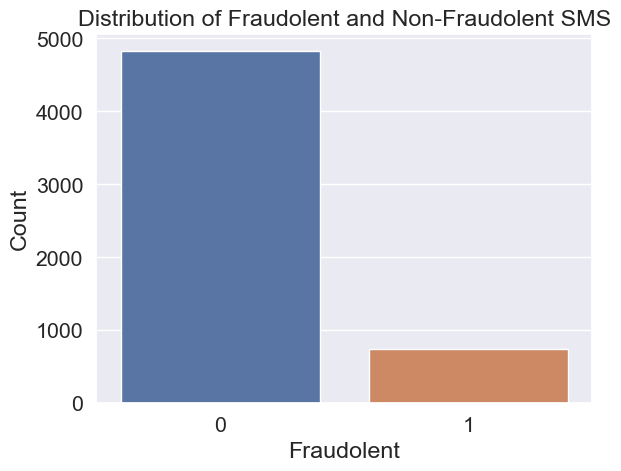

In [120]:
print("Summary Statistics:")
print(df.describe())

sns.countplot(data=df, x="Fraudolent")
plt.title('Distribution of Fraudolent and Non-Fraudolent SMS')
plt.xlabel('Fraudolent')
plt.ylabel('Count')
plt.show()



We can understand that our variable is either 0 or 1 and the frequency of each case in our data. There is almost five times more non fraudolent SMS messages than fraudolent ones.

We will now analyse if there is any relationship between the length of the SMS messages and them being fraudolent or not. 

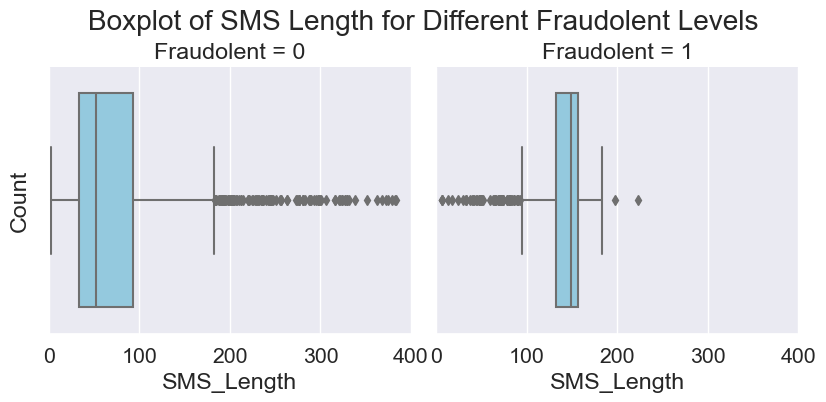

In [121]:
# Calculate the length of each SMS message
df['SMS_Length'] = df['SMS_test'].apply(len)

# Create a FacetGrid and box plot
g = sns.FacetGrid(df, col='Fraudolent', height=4, col_wrap=2)

g.map(sns.boxplot, 'SMS_Length', color='skyblue')

g.set_axis_labels('SMS_Length', 'Count')
g.fig.suptitle('Boxplot of SMS Length for Different Fraudolent Levels', y=1.02)

g.set(xlim=(0, 400)) 

plt.show()

From the box plot we can conclude that fraudolent messages are in average longer than the average non fraudolent messages. However,  the range of SMS lenth seams to be similar. Lets look at the correlation between SMS length and Fraudolent to better understand the relationship.

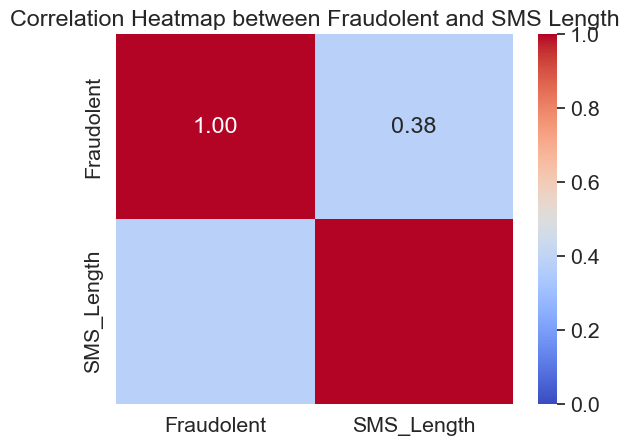

In [122]:
# Calculate the correlation matrix
correlation_matrix = df[['Fraudolent', 'SMS_Length']].corr()

# Plot a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=0, vmax=1)
plt.title('Correlation Heatmap between Fraudolent and SMS Length')

plt.show()


A 0.38 correlation is still lower than 0.4 so this would be considered a week correlation. There is some degree of association between the two variables but it is not particularly strong.



We will now look at if there is any relationship between the number of digits (numbers between 0 and 9) and Fraudolent.

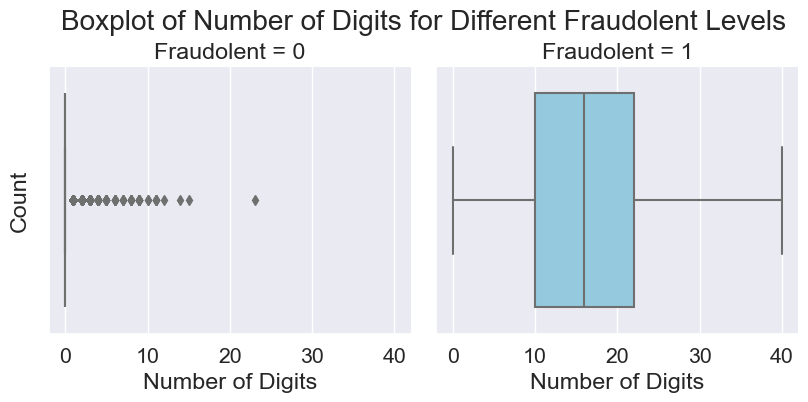

In [123]:
# Calculate the number of digits in each SMS message
df['Number_of_Digits'] = df['SMS_test'].apply(lambda x: sum(c.isdigit() for c in x))

# Create a FacetGrid and box plot
g = sns.FacetGrid(df, col='Fraudolent', height=4, col_wrap=2)

g.map(sns.boxplot, 'Number_of_Digits', color='skyblue')

g.set_axis_labels('Number of Digits', 'Count')
g.fig.suptitle('Boxplot of Number of Digits for Different Fraudolent Levels', y=1.02)


plt.show()


It looks like non fraudolent SMS messages usually don't have numeric digits while fraudolent ones do. This could be an interesting feature to have in mind. Lets look at the correlation between Number of digits in SMS and Fraudolent to better understand the relationship.

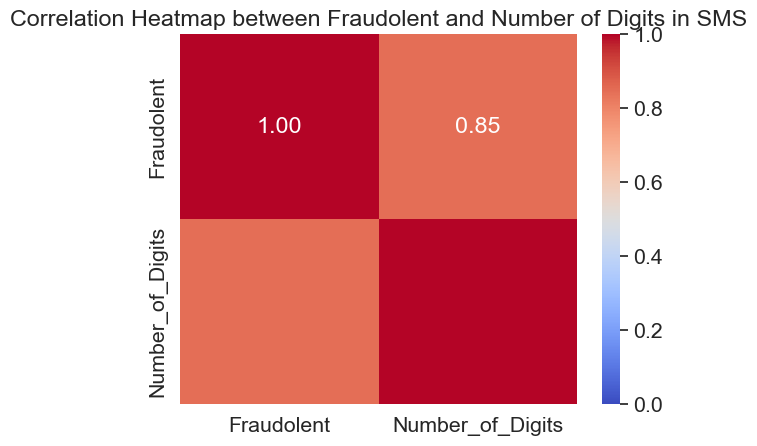

In [124]:
# Calculate the correlation matrix
correlation_matrix = df[['Fraudolent', 'Number_of_Digits']].corr()

# Plot a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=0, vmax=1)
plt.title('Correlation Heatmap between Fraudolent and Number of Digits in SMS')

plt.show()

A correlation of 0.85 is higher than 0.8 so it is considered a very strong correlation. This indicates a robust and high degree of positive correlation between the two variables.

<h2 id="section3">Data Preprocessing</h2>

<h3>Train-Test-Split</h3>

In [125]:
# splitting the dataframe into training set and test set
# X = df["SMS test"]
# y = df["Fraudolent"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=
#                                                     0.25, random_state=1)
TRAIN_TEST_SPLIT = 3714

#training dataset
train_text=df.SMS_test[:TRAIN_TEST_SPLIT]
train_sentiments=df.Fraudolent[:TRAIN_TEST_SPLIT]

#testing dataset
test_text=df.SMS_test[TRAIN_TEST_SPLIT:]
test_sentiments=df.Fraudolent[TRAIN_TEST_SPLIT:]

print(train_text.shape, train_sentiments.shape)
print(test_text.shape, test_sentiments.shape)


(3714,) (3714,)
(1858,) (1858,)


<h3 style="color: red;">Text Normalization</h3>

In [126]:
# normalizing text
nltk.download('stopwords')

# tokenizing text
tokenizer=ToktokTokenizer()

# setting english stopwords
stopword_list=nltk.corpus.stopwords.words('english')

# defining function to remove html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# applying denoise-function to text column
df['SMS_test']=df['SMS_test'].apply(strip_html)

# defining function to remove square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# applying denoise-function to text column
df['SMS_test']=df['SMS_test'].apply(remove_between_square_brackets)

# defining function to remove noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

# applying denoise-function to text column
df['SMS_test']=df['SMS_test'].apply(denoise_text)

# defining function to remove special characters
def remove_special_characters(text):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

# applying special-characters-function to text column
df['SMS_test']=df['SMS_test'].apply(remove_special_characters)

# defining function to stemm the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

# applying stemming-function to text column
df['SMS_test']=df['SMS_test'].apply(simple_stemmer)

# setting stopwords to english
stop=set(stopwords.words('english'))
print(stop)

# defining function to remove stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

# applying -stopword-function to text column
df['SMS_test']=df['SMS_test'].apply(remove_stopwords)

print(df['SMS_test'])


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\feder\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'your', 'he', 'hasn', 'shan', 'on', 'its', 'was', 'through', 'have', 'and', 'here', 'but', 'being', 'himself', 'her', 'out', 'how', 'it', 'between', "hadn't", 'now', 'just', 'i', 't', "should've", 'again', 'weren', 'she', 'over', 'myself', 'each', 've', 'most', 'themselves', 'shouldn', 'same', 'am', 'both', 'mustn', 'couldn', 'did', 'down', 'too', 'until', 'they', 'during', 'into', 'ourselves', 'only', 'of', "didn't", 'that', 'is', 'as', 'very', "weren't", "won't", 'no', 'or', "that'll", 'should', 'before', 'once', 'yours', 'those', 'where', 'do', "you're", 'ours', 'isn', 'than', 'this', "needn't", 'which', 'by', 'theirs', 'when', 'own', 'their', 'doing', 'were', 'y', 'be', 'm', 'you', "it's", 'are', 'from', 'o', 'under', 'we', 'can', 'does', 'herself', 'these', 'ain', 'him', "mustn't", 'didn', "you'll", 'my', 'then', "shan't", "isn't", 'a', 'at', "couldn't", 'itself', 'me', 'some', 'so', 'there', 'has', 'll', 'haven', 'our', 'needn', 'mightn', 'had', 'while', 'against', 'an', "don't"

In [127]:
# normalizing training text
norm_train_text=df.SMS_test[:TRAIN_TEST_SPLIT]
norm_train_text[0]
print(len(norm_train_text))

# Normalizing testing text
norm_test_text=df.SMS_test[TRAIN_TEST_SPLIT:]
norm_test_text[4000]
print(len(norm_test_text))
print(norm_test_text)


3714
1858
3714                              carlo say hell mu minut
3715    dun thk ill quit yet hmmm go jazz yogasana oso...
3716    uve bin award 50 play 4 instant cash call 0871...
3717    love ha one law make happi person love way fri...
3718    pleas call amanda regard renew upgrad current ...
                              ...                        
5567    hi wlcome back wonder got eaten lion someth no...
5568                                 sorri ill call later
5569                prabhaim sorydarealyfrm heart im sori
5570                                 nt joke serious told
5571                              say somebodi name tampa
Name: SMS_test, Length: 1858, dtype: object


<h3>Transforming Text with Bag of Words</h3>

In [128]:
#Count vectorizer for BoW
cv = CountVectorizer(min_df=0.0,max_df=1.0,binary=True,ngram_range=(1,3))

#transforming the training text
cv_train_text = cv.fit_transform(norm_train_text)

#transforming the testing text
cv_test_text = cv.transform(norm_test_text)

print('BOW_cv_train:', cv_train_text.shape)
print('BOW_cv_test:', cv_test_text.shape)

print(cv_train_text.__class__)

# Normalize the BoW features in the training set
normalized_cv_train_text = normalize(cv_train_text, norm='l1', axis=1)

# Normalize the BoW features in the testing set
normalized_cv_test_text = normalize(cv_test_text, norm='l1', axis=1)

print('Normalized BOW_cv_train:', normalized_cv_train_text.shape)
print('Normalized BOW_cv_test:', normalized_cv_test_text.shape)

print(normalized_cv_train_text.__class__)


BOW_cv_train: (3714, 51158)
BOW_cv_test: (1858, 51158)
<class 'scipy.sparse._csr.csr_matrix'>
Normalized BOW_cv_train: (3714, 51158)
Normalized BOW_cv_test: (1858, 51158)
<class 'scipy.sparse._csr.csr_matrix'>


Since the output given from using a count vectorizer is not immediately normalized and some of the models used require normalized input we define both a normalized and a non normalized version of the text.

Additionally, we will use TF-IDF as an alternative way to transform the text and it's output is allways normalized.

<h3>Transforming Text with TF-IDF</h3>

In [129]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0.0,max_df=1.0,use_idf=True,ngram_range=(1,3))

#transforming training text
tv_train_text=tv.fit_transform(norm_train_text)

#transforming testing text
tv_test_text=tv.transform(norm_test_text)

print('Tfidf_train:', tv_train_text.shape)
print('Tfidf_test:', tv_test_text.shape)

print(tv_train_text.__class__)


Tfidf_train: (3714, 51158)
Tfidf_test: (1858, 51158)
<class 'scipy.sparse._csr.csr_matrix'>


As we can see the output from both vectorizers is a scipy sparse csr matrix. In SciPy these are highly efficient and memory-effective at representing and manipulating large, sparse matrices (mostly filled with zeros) in Python. As such we can work with these for most of the following models except for the ANN (transformation shown later).

<h2 id="section4">Models</h2>

The objective is to design a mechanism that identifies and flags fraudulent messages automatically by distinguishing them from non-fraudulent messages. Therefore we face a classification problem. Since the training data is already labled according to this distinction we will be training and testing using primarily supervised machine learning algorithms and finally comparing the performace of these with an alternative approach by using an Artificial Neural Network.

In [130]:
# keeping track of all results during training and testing
default_conf_matrices = {}
best_hyperparameters = {}
best_conf_matrices = {}
f1_scores = {}


<h3>Model 1: Logistic Regression</h3>

<strong style="color: red;">First, create a validation set from the training set to analyze the behaviour with the default hyperparameters</strong>

In [131]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)


<h5>Training with Bag of words</h5>

In [132]:
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_text,train_sentiments)

#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_text)


<h5>Testing with Bag of Words</h5>

lr_bow_score : 0.9628632938643703
                precision    recall  f1-score   support

Non-Fraudolent       0.96      1.00      0.98      1606
    Fraudolent       1.00      0.73      0.84       252

      accuracy                           0.96      1858
     macro avg       0.98      0.86      0.91      1858
  weighted avg       0.96      0.96      0.96      1858



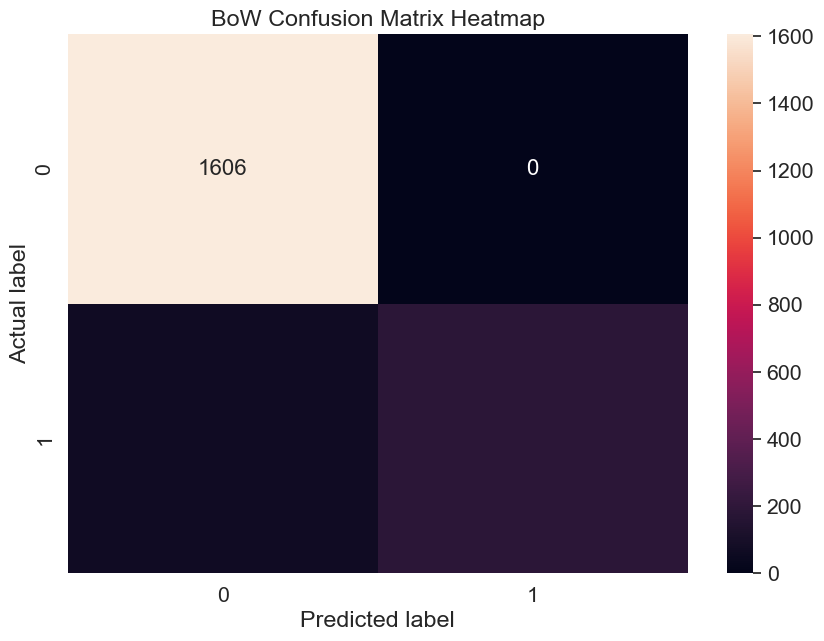

In [133]:
# Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)

# Classification report for bag of words
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=["Non-Fraudolent","Fraudolent"])
print(lr_bow_report)

# confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,lr_bow_predict,labels=[0,1])
default_conf_matrices["lr_bow"] = cm_bow

plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_bow, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('BoW Confusion Matrix Heatmap')
plt.show()


Here we define the k-cross-fold validation process in a single function so that we can call it every time we need to use it instead of repeating the code. The output is the best set of hyperparameters found by the grid search. 

In [134]:
# Specify the parameter grid
def k_cross_v(model, param_grid, x_train, y_train, n_splits=5, n_jobs=-1, scoring='f1'):
  # Create a KFold object
  kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

  # Create the GridSearchCV object
  grid_search = GridSearchCV(model, param_grid, scoring=scoring, cv=kf, n_jobs=n_jobs)

  # Fit the model to the data
  grid_search.fit(x_train, y_train)

  # Extracting results
  results = grid_search.cv_results_
  results_df = pd.DataFrame(results).sort_values(by='rank_test_score')
  results_df.reset_index(drop=True, inplace=True)
  best_hyperparameters = results_df["params"][0]

  return best_hyperparameters


K-Cross Fold Validation to find the best set of hyperparameters

In [135]:
params_lr = {'penalty': ["l2", "elasticnet", None], 'max_iter': [400, 500, 600, 700], 'C': [0.5, 1, 1.5]}

lr_hyperparameters = k_cross_v(lr, params_lr, cv_train_text, train_sentiments)

print(lr_hyperparameters)


{'C': 1, 'max_iter': 500, 'penalty': None}


Now that we have the best hyperparameters for this model, we will define it once again but with the tuned hyperparameters and run it to compute the confusion matrix. 

lr_bow_score : 0.9666307857911733
                precision    recall  f1-score   support

Non-Fraudolent       0.96      1.00      0.98      1606
    Fraudolent       1.00      0.75      0.86       252

      accuracy                           0.97      1858
     macro avg       0.98      0.88      0.92      1858
  weighted avg       0.97      0.97      0.96      1858



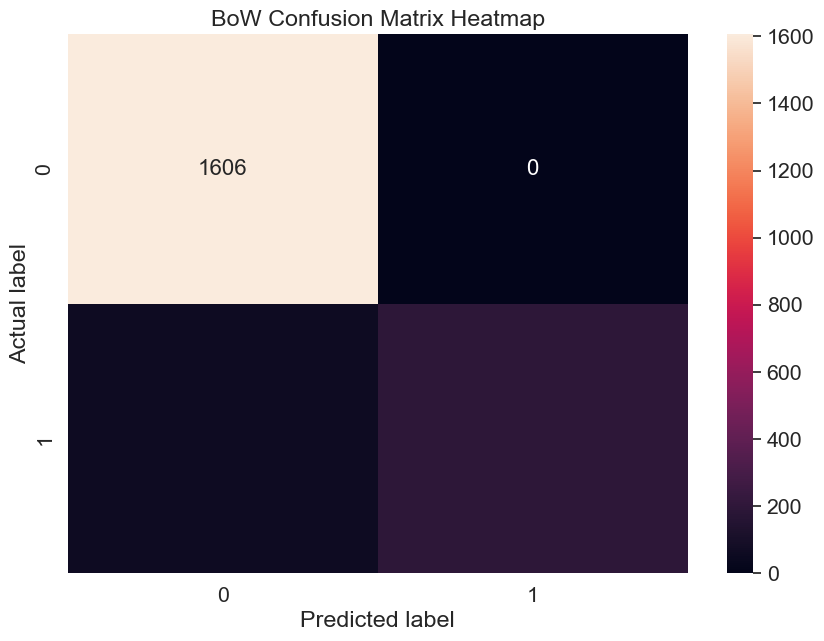

In [136]:
best_lr = LogisticRegression(penalty=lr_hyperparameters['penalty'], max_iter=lr_hyperparameters['max_iter'], C=lr_hyperparameters['C'])
#Fitting the model for Bag of words
lr_bow = best_lr.fit(cv_train_text,train_sentiments)

#Predicting the model for bag of words
lr_bow_predict=best_lr.predict(cv_test_text)
# Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)

# Classification report for bag of words
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=["Non-Fraudolent","Fraudolent"])
print(lr_bow_report)

# confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,lr_bow_predict,labels=[0,1])
best_conf_matrices["lr_bow"] = cm_bow
f1_scores["lr_bow"] = f1_score(test_sentiments, lr_bow_predict)

plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_bow, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('BoW Confusion Matrix Heatmap')
plt.show()


<h5>Training with TF-IDF</h5>

In [137]:
# Fitting the model for tfidf features
lr_tfidf = lr.fit(tv_train_text,train_sentiments)

# Predicting the model for tfidf features
lr_tfidf_predict = lr.predict(tv_test_text)


<h5>Testing with TF-IDF</h5>

lr_tfidf_score : 0.9257265877287406
                precision    recall  f1-score   support

Non-Fraudolent       0.92      1.00      0.96      1606
    Fraudolent       0.97      0.46      0.63       252

      accuracy                           0.93      1858
     macro avg       0.95      0.73      0.79      1858
  weighted avg       0.93      0.93      0.91      1858



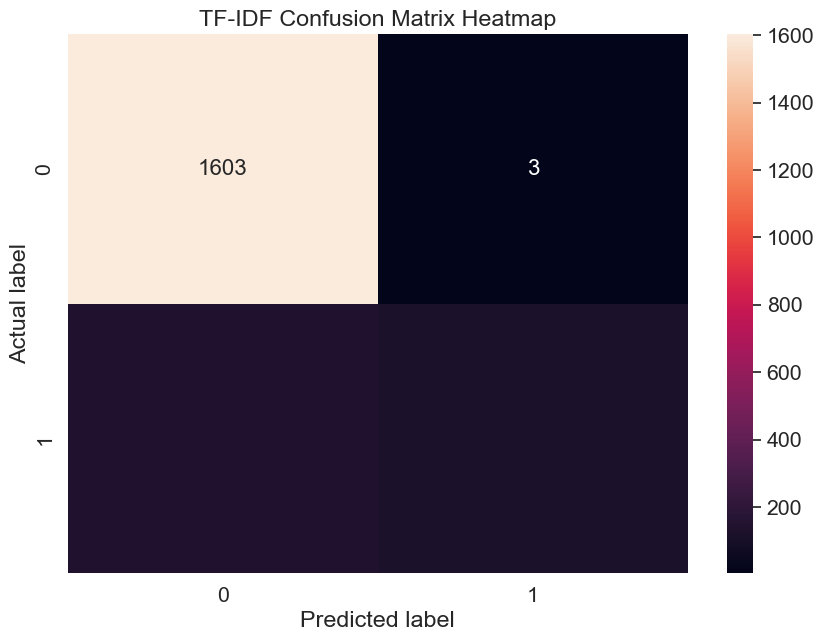

In [138]:
# Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

# Classification report for tfidf features
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=["Non-Fraudolent","Fraudolent"])
print(lr_tfidf_report)

#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,lr_tfidf_predict,labels=[0,1])
default_conf_matrices["lr_tfidf"] = cm_tfidf

plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_tfidf, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('TF-IDF Confusion Matrix Heatmap')
plt.show()


K-Cross Fold Validation to find the best set of hyperparameters

In [139]:
# Specify the parameter grid
params_lr = {'penalty': ["l2", "elasticnet", None], 'max_iter': [400, 500, 600, 700], 'C': [0.5, 1, 1.5]}

lr_hyperparameters = k_cross_v(lr, params_lr, tv_train_text, train_sentiments)

print(lr_hyperparameters)


{'C': 1, 'max_iter': 500, 'penalty': None}


Now that we have the best hyperparameters for this model, we will define it once again but with the tuned hyperparameters and run it to compute the confusion matrix. 

lr_tfidf_score : 0.976318622174381
                precision    recall  f1-score   support

Non-Fraudolent       0.99      0.99      0.99      1606
    Fraudolent       0.91      0.91      0.91       252

      accuracy                           0.98      1858
     macro avg       0.95      0.95      0.95      1858
  weighted avg       0.98      0.98      0.98      1858



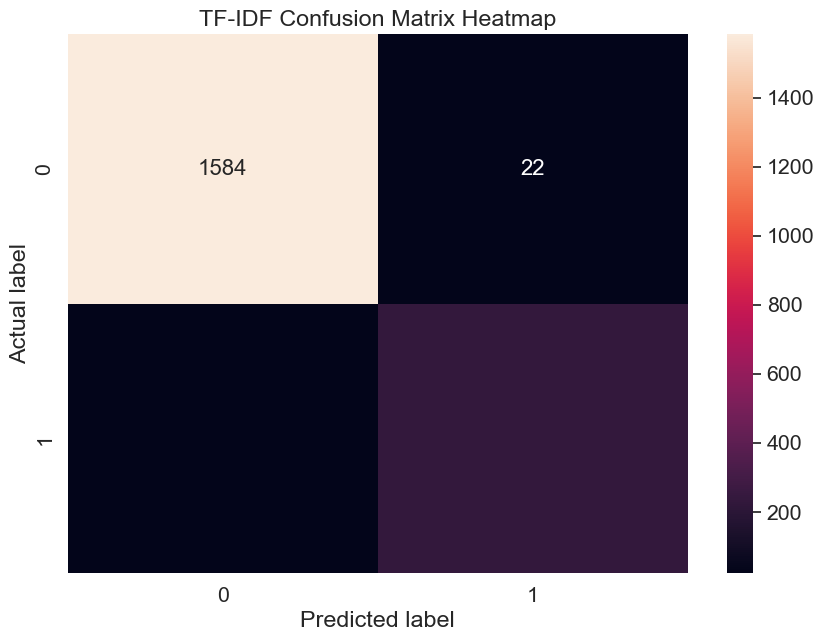

In [140]:
lr = LogisticRegression(penalty=lr_hyperparameters['penalty'], max_iter=lr_hyperparameters['max_iter'], C=lr_hyperparameters['C'])
#Fitting the model for TF-IDF
lr_tfidf = lr.fit(tv_train_text,train_sentiments)

#Predicting the model for bag of words
lr_tfidf_predict=lr.predict(tv_test_text)
# Accuracy score for bag of words
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

# Classification report for bag of words
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=["Non-Fraudolent","Fraudolent"])
print(lr_tfidf_report)

# confusion matrix for bag of words
cm_tfidf=confusion_matrix(test_sentiments,lr_tfidf_predict,labels=[0,1])
best_conf_matrices["lr_tfidf"] = cm_tfidf
f1_scores["lr_tfidf"] = f1_score(test_sentiments, lr_tfidf_predict)


plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_tfidf, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('TF-IDF Confusion Matrix Heatmap')
plt.show()


<h3>Model 2: Linear and Kernel SVM</h3>

<h4>Linear SVM</h4>

In [141]:
#training the linear svm
svm=SGDClassifier(loss='hinge',max_iter=500,random_state=42)


<h5>Training with Bag of Words</h5>

In [142]:
#fitting the svm for bag of words
svm_bow=svm.fit(normalized_cv_train_text,train_sentiments)

#Predicting the model for bag of words
svm_bow_predict=svm.predict(normalized_cv_test_text)


<h5>Testing with Bag of Words</h5>

svm_bow_score : 0.8681377825618946
                precision    recall  f1-score   support

Non-Fraudolent       0.87      1.00      0.93      1606
    Fraudolent       0.82      0.04      0.07       252

      accuracy                           0.87      1858
     macro avg       0.84      0.52      0.50      1858
  weighted avg       0.86      0.87      0.81      1858



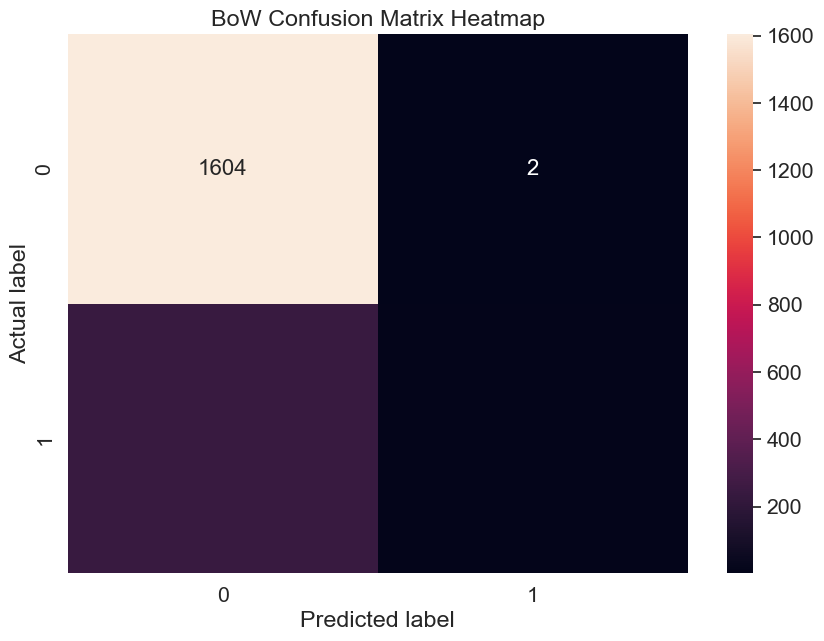

In [143]:
#Accuracy score for bag of words
svm_bow_score=accuracy_score(test_sentiments,svm_bow_predict)
print("svm_bow_score :",svm_bow_score)

#Classification report for bag of words
svm_bow_report=classification_report(test_sentiments,svm_bow_predict,target_names=["Non-Fraudolent","Fraudolent"])
print(svm_bow_report)

#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,svm_bow_predict,labels=[0,1])
default_conf_matrices["svm_bow"] = cm_bow

plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_bow, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('BoW Confusion Matrix Heatmap')
plt.show()


K-Cross Fold Validation to find the best set of hyperparameters

In [144]:
# Specify the parameter grid
param_grid = {'loss': ['log_loss', 'modified_huber', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'], 'learning_rate': ["constant", "optimal", "adaptive"], 'max_iter': [400, 500, 600, 700]}

svm_bow_hyperparameters = k_cross_v(svm, param_grid, normalized_cv_train_text, train_sentiments)

print(svm_bow_hyperparameters)


{'learning_rate': 'optimal', 'loss': 'perceptron', 'max_iter': 700}


Now that we have the best hyperparameters for this model, we will define it once again but with the tuned hyperparameters and run it to compute the confusion matrix. 

svm_bow_score : 0.957481162540366
                precision    recall  f1-score   support

Non-Fraudolent       0.97      0.98      0.98      1606
    Fraudolent       0.86      0.82      0.84       252

      accuracy                           0.96      1858
     macro avg       0.92      0.90      0.91      1858
  weighted avg       0.96      0.96      0.96      1858



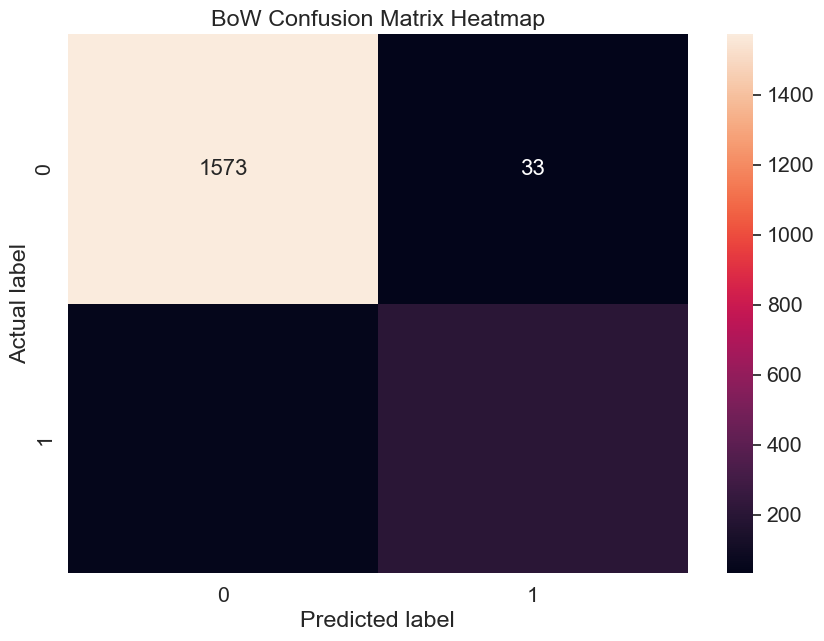

In [145]:
best_svm = SGDClassifier(learning_rate=svm_bow_hyperparameters['learning_rate'], max_iter=svm_bow_hyperparameters['max_iter'], loss=svm_bow_hyperparameters['loss'])
#Fitting the model for Bag of words
svm_bow = best_svm.fit(normalized_cv_train_text,train_sentiments)

#Predicting the model for bag of words
svm_bow_predict=best_svm.predict(normalized_cv_test_text)
# Accuracy score for bag of words
svm_bow_score=accuracy_score(test_sentiments,svm_bow_predict)
print("svm_bow_score :",svm_bow_score)

# Classification report for bag of words
svm_bow_report=classification_report(test_sentiments,svm_bow_predict,target_names=["Non-Fraudolent","Fraudolent"])
print(svm_bow_report)

# confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,svm_bow_predict,labels=[0,1])
best_conf_matrices["svm_bow"] = cm_bow
f1_scores["svm_bow"] = f1_score(test_sentiments, svm_bow_predict)



plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_bow, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('BoW Confusion Matrix Heatmap')
plt.show()


<h5>Training with TF-IDF</h5>

In [146]:
#fitting the svm for tfidf features
svm_tfidf=svm.fit(tv_train_text,train_sentiments)

#Predicting the model for tfidf features
svm_tfidf_predict=svm.predict(tv_test_text)


<h5>Testing with TF-IDF</h5>

svm_tfidf_score : 0.9773950484391819
                precision    recall  f1-score   support

Non-Fraudolent       0.98      0.99      0.99      1606
    Fraudolent       0.95      0.88      0.91       252

      accuracy                           0.98      1858
     macro avg       0.97      0.94      0.95      1858
  weighted avg       0.98      0.98      0.98      1858



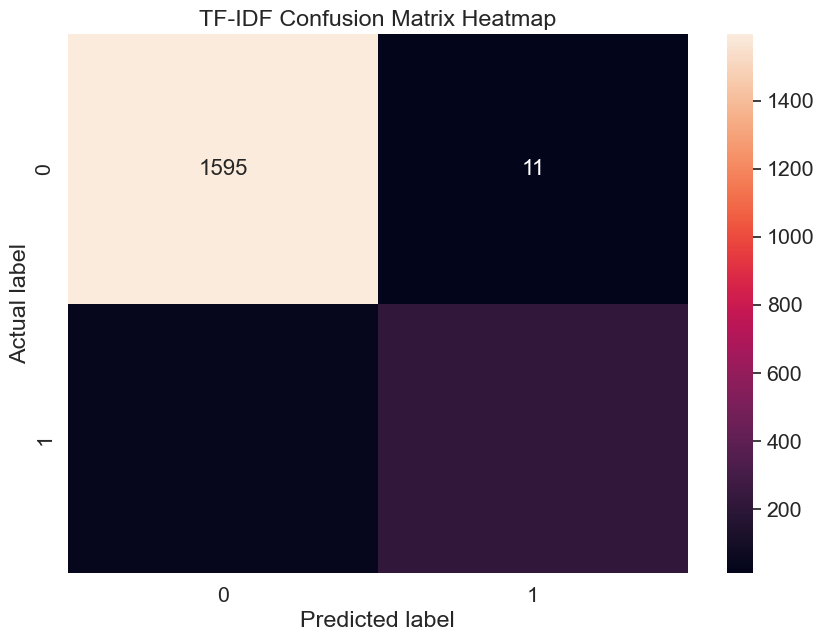

In [147]:
#Accuracy score for tfidf features
svm_tfidf_score=accuracy_score(test_sentiments,svm_tfidf_predict)
print("svm_tfidf_score :",svm_tfidf_score)

#Classification report for tfidf features
svm_tfidf_report=classification_report(test_sentiments,svm_tfidf_predict,target_names=["Non-Fraudolent","Fraudolent"])
print(svm_tfidf_report)

#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,svm_tfidf_predict,labels=[0,1])
default_conf_matrices["svm_tfidf"] = cm_tfidf

plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_tfidf, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('TF-IDF Confusion Matrix Heatmap')
plt.show()


K-Cross Fold Validation to find the best set of hyperparameters

In [148]:
# Specify the parameter grid
param_grid = {'loss': [ 'hinge','log_loss', 'modified_huber', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'], 'learning_rate': ["constant", "optimal", "adaptive"], 'max_iter': [400, 500, 600, 700]}

svm_tfidf_hyperparameters = k_cross_v(svm, param_grid, tv_train_text, train_sentiments)

print(svm_tfidf_hyperparameters)


{'learning_rate': 'optimal', 'loss': 'perceptron', 'max_iter': 700}


Now that we have the best hyperparameters for this model, we will define it once again but with the tuned hyperparameters and run it to compute the confusion matrix. 

svm_tfidf_score : 0.9736275565123789
                precision    recall  f1-score   support

Non-Fraudolent       0.99      0.98      0.98      1606
    Fraudolent       0.90      0.90      0.90       252

      accuracy                           0.97      1858
     macro avg       0.94      0.94      0.94      1858
  weighted avg       0.97      0.97      0.97      1858



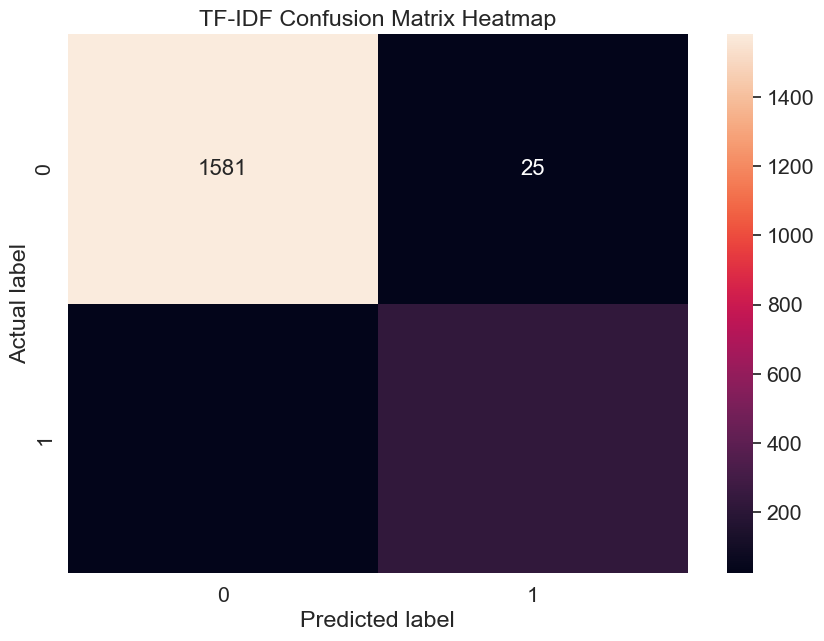

In [149]:
best_svm = SGDClassifier(learning_rate=svm_tfidf_hyperparameters['learning_rate'], max_iter=svm_tfidf_hyperparameters['max_iter'], loss=svm_tfidf_hyperparameters['loss'])
#Fitting the model for TF-IDF
svm_tfidf = best_svm.fit(tv_train_text,train_sentiments)

#Predicting the model for TF-IDF
svm_tfidf_predict=best_svm.predict(tv_test_text)
# Accuracy score for TF-IDF
svm_tfidf_score=accuracy_score(test_sentiments,svm_tfidf_predict)
print("svm_tfidf_score :",svm_tfidf_score)

# Classification report for TF-IDF
svm_tfidf_report=classification_report(test_sentiments,svm_tfidf_predict,target_names=["Non-Fraudolent","Fraudolent"])
print(svm_tfidf_report)

# confusion matrix for TF-IDF
cm_tfidf=confusion_matrix(test_sentiments,svm_tfidf_predict,labels=[0,1])
best_conf_matrices["svm_tfidf"] = cm_tfidf
f1_scores["svm_tfidf"] = f1_score(test_sentiments, svm_tfidf_predict)


plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_tfidf, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('TF-IDF Confusion Matrix Heatmap')
plt.show()


<h4>Kernel SVM</h4>

In [150]:
ksvm = SVC(kernel = 'poly', random_state = 0)


<h5>Training with Bag of Words</h5>

In [151]:
#fitting the ksvm for bow features
ksvm_bow = ksvm.fit(cv_train_text, train_sentiments)

# Predicting the Test set results
ksvm_bow_predict = ksvm.predict(cv_test_text)


<h5>Testing with Bag of Words</h5>

svm_bow_score : 0.9133476856835306
                precision    recall  f1-score   support

Non-Fraudolent       0.91      1.00      0.95      1606
    Fraudolent       1.00      0.36      0.53       252

      accuracy                           0.91      1858
     macro avg       0.95      0.68      0.74      1858
  weighted avg       0.92      0.91      0.90      1858



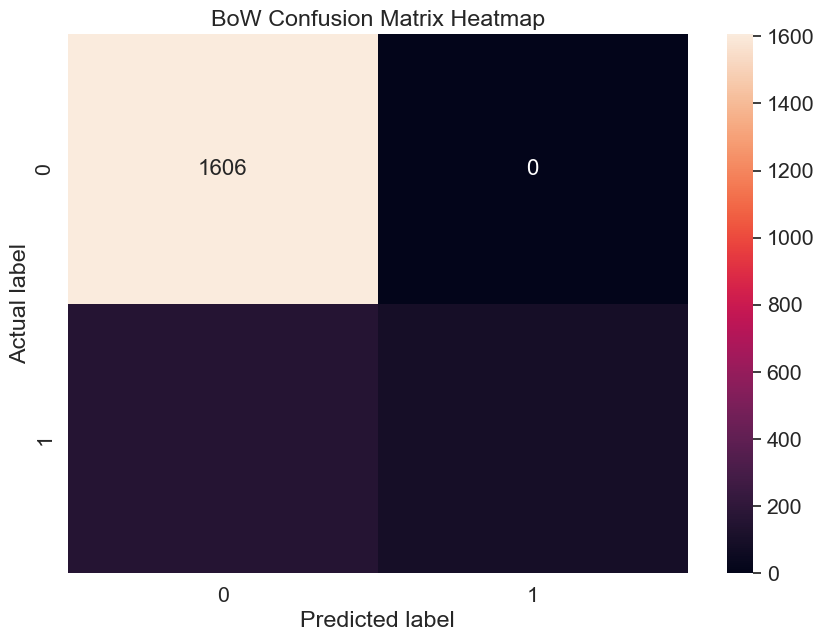

In [152]:
#Accuracy score for bag of words
acc_bow=accuracy_score(test_sentiments,ksvm_bow_predict)
print("svm_bow_score :",acc_bow)

#Classification report for bag of words
bow_report=classification_report(test_sentiments,ksvm_bow_predict,target_names=["Non-Fraudolent","Fraudolent"])
print(bow_report)

#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,ksvm_bow_predict,labels=[0,1])
default_conf_matrices["ksvm_bow"] = cm_bow

plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_bow, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('BoW Confusion Matrix Heatmap')
plt.show()


K-Cross Fold Validation to find the best set of hyperparameters

In [153]:
# Specify the parameter grid
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'max_iter': [400, 500, 600, 700], 'gamma': ["scale", "auto"]}

ksvm_bow_hyperparameters = k_cross_v(ksvm, param_grid, cv_train_text, train_sentiments)

print(ksvm_bow_hyperparameters)


{'gamma': 'scale', 'kernel': 'sigmoid', 'max_iter': 400}


Now that we have the best hyperparameters for this model, we will define it once again but with the tuned hyperparameters and run it to compute the confusion matrix. 

ksvm_bow_score : 0.9720129171151776
                precision    recall  f1-score   support

Non-Fraudolent       0.97      1.00      0.98      1606
    Fraudolent       1.00      0.79      0.88       252

      accuracy                           0.97      1858
     macro avg       0.98      0.90      0.93      1858
  weighted avg       0.97      0.97      0.97      1858



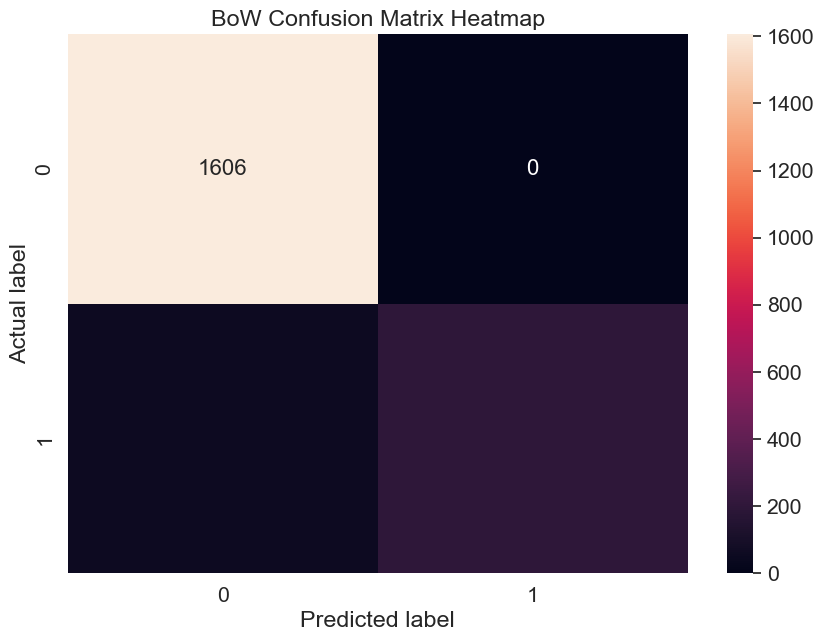

In [154]:
best_ksvm = SVC(gamma=ksvm_bow_hyperparameters['gamma'], max_iter=ksvm_bow_hyperparameters['max_iter'], kernel=ksvm_bow_hyperparameters['kernel'])
#Fitting the model for Bag of words
ksvm_bow = best_ksvm.fit(cv_train_text,train_sentiments)

#Predicting the model for bag of words
ksvm_bow_predict=best_ksvm.predict(cv_test_text)
# Accuracy score for bag of words
ksvm_bow_score=accuracy_score(test_sentiments,ksvm_bow_predict)
print("ksvm_bow_score :",ksvm_bow_score)

# Classification report for bag of words
ksvm_bow_report=classification_report(test_sentiments,ksvm_bow_predict,target_names=["Non-Fraudolent","Fraudolent"])
print(ksvm_bow_report)

# confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,ksvm_bow_predict,labels=[0,1])
best_conf_matrices["ksvm_bow"] = cm_bow
f1_scores["ksvm_bow"] = f1_score(test_sentiments, ksvm_bow_predict)


plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_bow, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('BoW Confusion Matrix Heatmap')
plt.show()



<h5>Training with TF-IDF</h5>

In [155]:
ksvm_tfidf = ksvm.fit(tv_train_text, train_sentiments)
# Predicting the Test set results
ksvm_tfidf_predict = ksvm.predict(tv_test_text)


<h5>Testing with TF_IDF</h5>

ksvm_tfidf_score : 0.9095801937567277
                precision    recall  f1-score   support

Non-Fraudolent       0.91      1.00      0.95      1606
    Fraudolent       1.00      0.33      0.50       252

      accuracy                           0.91      1858
     macro avg       0.95      0.67      0.73      1858
  weighted avg       0.92      0.91      0.89      1858



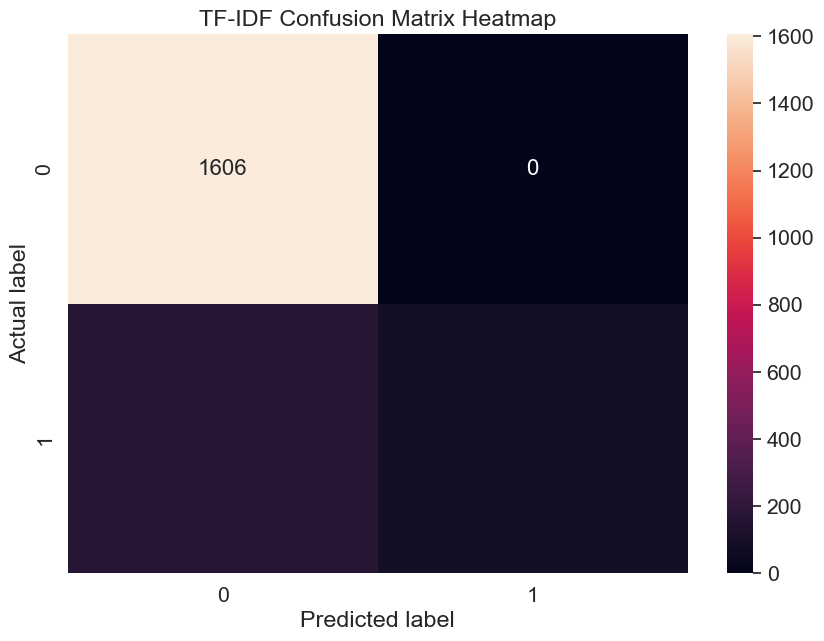

In [156]:
#Accuracy score for bag of words
acc_tfidf=accuracy_score(test_sentiments,ksvm_tfidf_predict)
print("ksvm_tfidf_score :",acc_tfidf)

#Classification report for bag of words
tfidf_report=classification_report(test_sentiments,ksvm_tfidf_predict,target_names=["Non-Fraudolent","Fraudolent"])
print(tfidf_report)

#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,ksvm_tfidf_predict,labels=[0,1])
default_conf_matrices["ksvm_tfidf"] = cm_tfidf

plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_tfidf, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('TF-IDF Confusion Matrix Heatmap')
plt.show()


K-Cross Fold Validation to find the best set of hyperparameters

In [157]:
# Specify the parameter grid
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'max_iter': [400, 500, 600, 700], 'gamma': ["scale", "auto"]}

ksvm_tfidf_hyperparameters = k_cross_v(ksvm, param_grid, tv_train_text, train_sentiments)

print(ksvm_tfidf_hyperparameters)

{'gamma': 'scale', 'kernel': 'linear', 'max_iter': 400}


Now that we have the best hyperparameters for this model, we will define it once again but with the tuned hyperparameters and run it to compute the confusion matrix. 

ksvm_tfidf_score : 0.9795479009687836
                precision    recall  f1-score   support

Non-Fraudolent       0.98      0.99      0.99      1606
    Fraudolent       0.95      0.89      0.92       252

      accuracy                           0.98      1858
     macro avg       0.97      0.94      0.96      1858
  weighted avg       0.98      0.98      0.98      1858



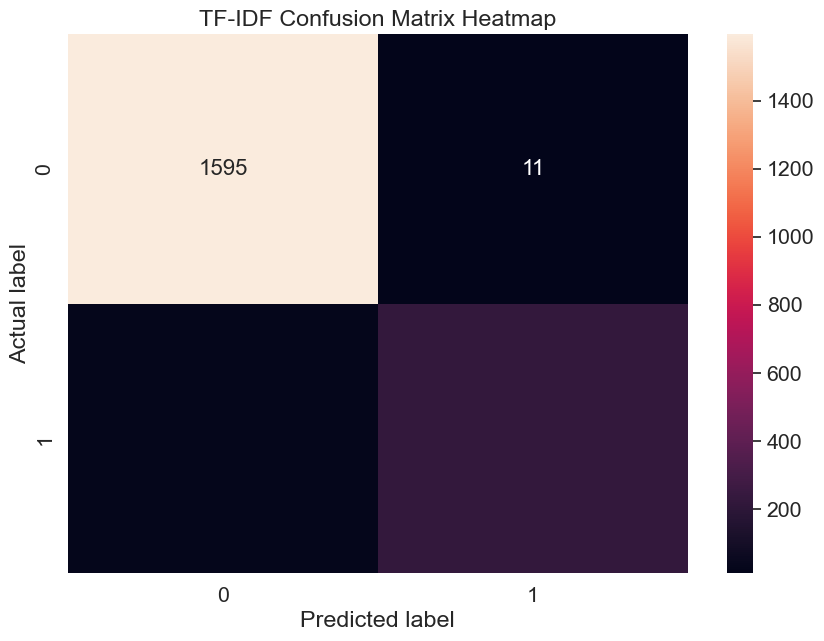

In [158]:
best_ksvm = SVC(gamma=ksvm_tfidf_hyperparameters['gamma'], max_iter=ksvm_tfidf_hyperparameters['max_iter'], kernel=ksvm_tfidf_hyperparameters['kernel'])
#Fitting the model for TF-IDF
ksvm_tfidf = best_ksvm.fit(tv_train_text,train_sentiments)

#Predicting the model for TF-IDF
ksvm_tfidf_predict=best_ksvm.predict(tv_test_text)
# Accuracy score for TF-IDF
ksvm_tfidf_score=accuracy_score(test_sentiments,ksvm_tfidf_predict)
print("ksvm_tfidf_score :",ksvm_tfidf_score)

# Classification report for TF-IDF
ksvm_tfidf_report=classification_report(test_sentiments,ksvm_tfidf_predict,target_names=["Non-Fraudolent","Fraudolent"])
print(ksvm_tfidf_report)

# confusion matrix for TF-IDF
cm_tfidf=confusion_matrix(test_sentiments,ksvm_tfidf_predict,labels=[0,1])
best_conf_matrices["ksvm_tfidf"] = cm_tfidf
f1_scores["ksvm_tfidf"] = f1_score(test_sentiments, ksvm_tfidf_predict)


plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_tfidf, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('TF-IDF Confusion Matrix Heatmap')
plt.show()


<h3>Model 3: Multinomial NB</h3>

In [159]:
#training the model
mnb=MultinomialNB()


Training with Bag of Words

In [160]:
#fitting the svm for bag of words
mnb_bow=mnb.fit(cv_train_text,train_sentiments)

#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_text)


mnb_bow_score : 0.9757804090419806
                precision    recall  f1-score   support

Non-Fraudolent       0.98      1.00      0.99      1606
    Fraudolent       0.96      0.85      0.91       252

      accuracy                           0.98      1858
     macro avg       0.97      0.92      0.95      1858
  weighted avg       0.98      0.98      0.98      1858



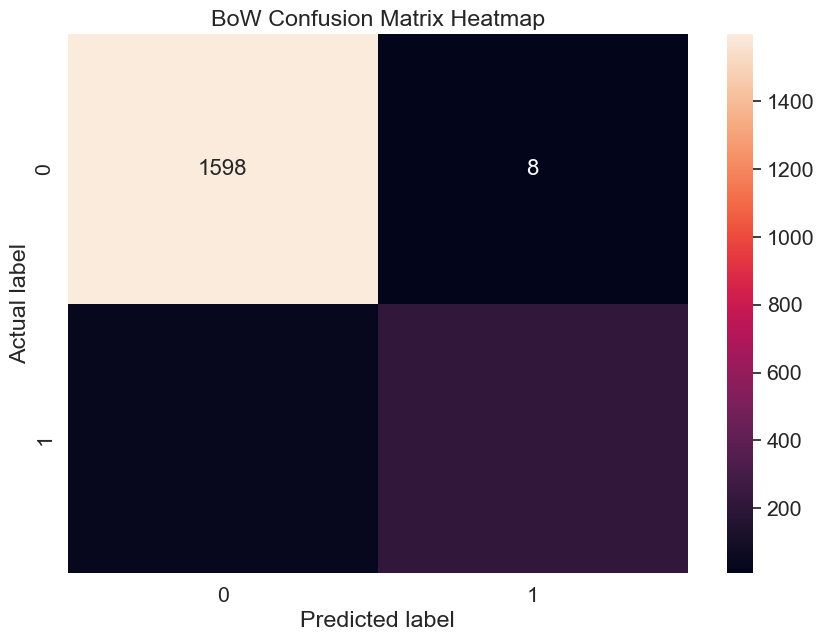

In [161]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)

#Classification report for bag of words
mnb_bow_report=classification_report(test_sentiments,mnb_bow_predict,target_names=["Non-Fraudolent","Fraudolent"])
print(mnb_bow_report)

#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,mnb_bow_predict,labels=[0,1])
default_conf_matrices["mnb_bow"] = cm_bow

plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_bow, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('BoW Confusion Matrix Heatmap')
plt.show()


K-Cross Fold Validation to find the best set of hyperparameters

In [162]:
# Specify the parameter grid
param_grid = {'alpha': [0.5,1,1.5,2]}

mnb_bow_hyperparameters = k_cross_v(mnb, param_grid, cv_train_text, train_sentiments)

print(mnb_bow_hyperparameters)


{'alpha': 2}


Now that we have the best hyperparameters for this model, we will define it once again but with the tuned hyperparameters and run it to compute the confusion matrix. 

mnb_bow_score : 0.9736275565123789
                precision    recall  f1-score   support

Non-Fraudolent       0.97      1.00      0.98      1606
    Fraudolent       0.98      0.83      0.89       252

      accuracy                           0.97      1858
     macro avg       0.97      0.91      0.94      1858
  weighted avg       0.97      0.97      0.97      1858



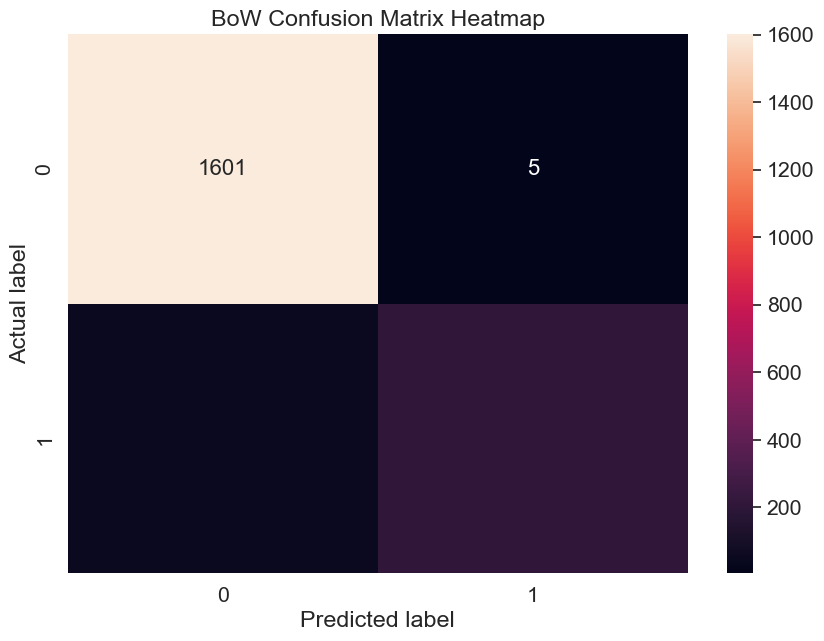

In [163]:
best_mnb = MultinomialNB(alpha=mnb_bow_hyperparameters['alpha'])
#Fitting the model for Bag of words
mnb_bow = best_mnb.fit(cv_train_text,train_sentiments)

#Predicting the model for bag of words
mnb_bow_predict=best_mnb.predict(cv_test_text)
# Accuracy score for bag of words
mnb_bow_score=accuracy_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)

# Classification report for bag of words
mnb_bow_report=classification_report(test_sentiments,mnb_bow_predict,target_names=["Non-Fraudolent","Fraudolent"])
print(mnb_bow_report)

# confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,mnb_bow_predict,labels=[0,1])
best_conf_matrices["mnb_bow"] = cm_bow
f1_scores["mnb_bow"] = f1_score(test_sentiments, mnb_bow_predict)


plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_bow, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('BoW Confusion Matrix Heatmap')
plt.show()

<h5>Training with TF-IDF</h5>

In [164]:
# fitting the svm for tfidf features
mnb_tfidf=mnb.fit(tv_train_text,train_sentiments)

#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_text)


<h5>Testing with TF-IDF</h5>

mnb_tfidf_score : 0.9311087190527448
                precision    recall  f1-score   support

Non-Fraudolent       0.93      1.00      0.96      1606
    Fraudolent       1.00      0.49      0.66       252

      accuracy                           0.93      1858
     macro avg       0.96      0.75      0.81      1858
  weighted avg       0.94      0.93      0.92      1858



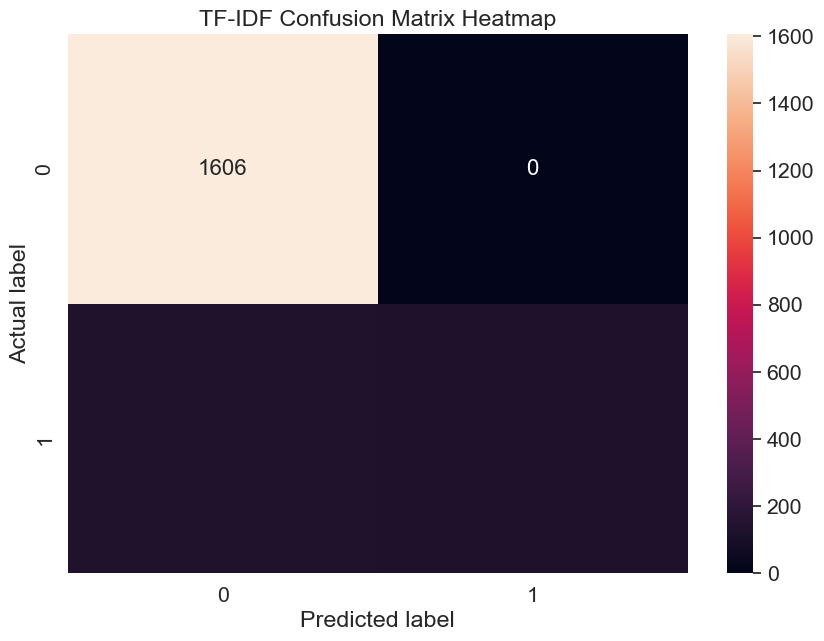

In [165]:
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)


#Classification report for tfidf features
mnb_tfidf_report=classification_report(test_sentiments,mnb_tfidf_predict,target_names=["Non-Fraudolent","Fraudolent"])
print(mnb_tfidf_report)


#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,mnb_tfidf_predict,labels=[0,1])
default_conf_matrices["mnb_tfidf"] = cm_tfidf

plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_tfidf, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('TF-IDF Confusion Matrix Heatmap')
plt.show()


K-Cross Fold Validation to find the best set of hyperparameters

In [166]:
# Specify the parameter grid
param_grid = {'alpha': [0.5,1,1.5,2]}

mnb_tfidf_hyperparameters = k_cross_v(mnb, param_grid, tv_train_text, train_sentiments)

print(mnb_tfidf_hyperparameters)

{'alpha': 0.5}


Now that we have the best hyperparameters for this model, we will define it once again but with the tuned hyperparameters and run it to compute the confusion matrix. 

mnb_tfidf_score : 0.9547900968783638
                precision    recall  f1-score   support

Non-Fraudolent       0.95      1.00      0.97      1606
    Fraudolent       1.00      0.67      0.80       252

      accuracy                           0.95      1858
     macro avg       0.98      0.83      0.89      1858
  weighted avg       0.96      0.95      0.95      1858



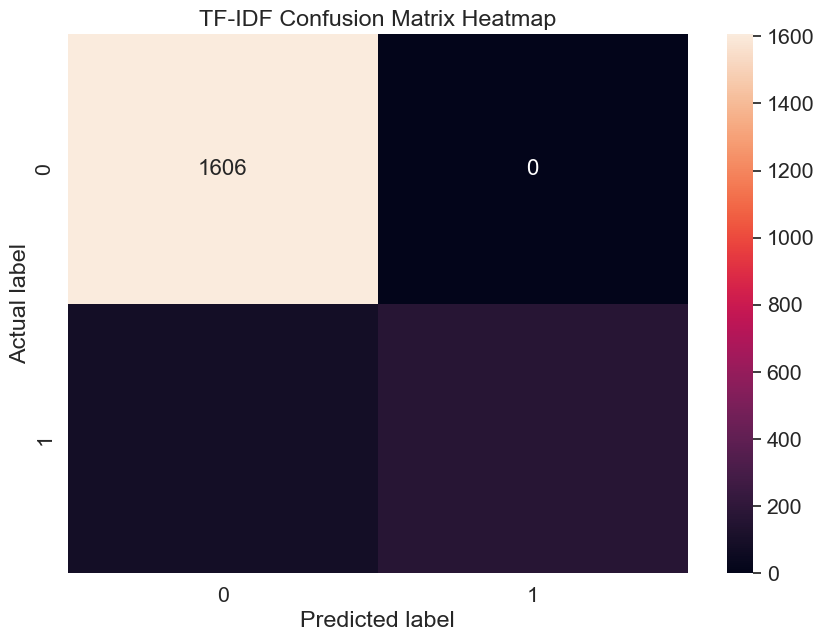

In [167]:
best_mnb = MultinomialNB(alpha=mnb_tfidf_hyperparameters['alpha'])
#Fitting the model for TF-IDF
mnb_tfidf = best_mnb.fit(tv_train_text,train_sentiments)

#Predicting the model for TF-IDF
mnb_tfidf_predict=best_mnb.predict(tv_test_text)
# Accuracy score for TF-IDF
mnb_tfidf_score=accuracy_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

# Classification report for TF-IDF
mnb_tfidf_report=classification_report(test_sentiments,mnb_tfidf_predict,target_names=["Non-Fraudolent","Fraudolent"])
print(mnb_tfidf_report)

# confusion matrix for TF-IDF
cm_tfidf=confusion_matrix(test_sentiments,mnb_tfidf_predict,labels=[0,1])
best_conf_matrices["mnb_tfidf"] = cm_tfidf
f1_scores["mnb_tfidf"] = f1_score(test_sentiments, mnb_tfidf_predict)


plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_tfidf, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('TF-IDF Confusion Matrix Heatmap')
plt.show()

<h3>Model 4: ANN</h3>

In [168]:
# Initialising the ANN
def ann_init():
  classifier = Sequential()

  # Adding the input layer and the first hidden layer
  classifier.add(Dense(units = 28, kernel_initializer = 'uniform', activation = 'relu', input_dim = 51158))

  # Adding the second hidden layer
  classifier.add(Dense(units = 20, kernel_initializer = 'uniform', activation = 'relu'))

  # Adding the third hidden layer
  classifier.add(Dense(units = 20, kernel_initializer = 'uniform', activation = 'relu'))

  # Adding the fourth hidden layer
  classifier.add(Dense(units = 20, kernel_initializer = 'uniform', activation = 'relu'))

  # Adding the output layer
  classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

  # Compiling the ANN
  classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

  return classifier

<h5>Training with Bag of Words</h5>

In [169]:
# initializing ANN
classifier = ann_init()
# transforming sparse csr matrix to numpy matrix using todense() function
print(type(cv_train_text))
dense_cv_train_text = normalized_cv_train_text.todense()
print(type(dense_cv_train_text))
# Fitting the ANN to the Training set
classifier.fit(dense_cv_train_text, train_sentiments, batch_size = 20, epochs = 5)


<class 'scipy.sparse._csr.csr_matrix'>
<class 'numpy.matrix'>
Epoch 1/5
186/186 [==============================] - 6s 23ms/step - loss: 0.5130 - accuracy: 0.8648
Epoch 2/5
186/186 [==============================] - 4s 24ms/step - loss: 0.2859 - accuracy: 0.8667
Epoch 3/5
186/186 [==============================] - 4s 24ms/step - loss: 0.1211 - accuracy: 0.8697
Epoch 4/5
186/186 [==============================] - 4s 24ms/step - loss: 0.0907 - accuracy: 0.9954
Epoch 5/5
186/186 [==============================] - 5s 25ms/step - loss: 0.0632 - accuracy: 0.9978


<h5>Testing with Bag of Words</h5>

In [170]:
# Predicting the Test set results
dense_cv_test_text = normalized_cv_test_text.todense()
y_pred = classifier.predict(dense_cv_test_text)
y_pred = (y_pred > 0.5)


59/59 [==============================] - 0s 5ms/step


ann_bow_score : 0.972551130247578
                precision    recall  f1-score   support

Non-Fraudolent       0.98      0.99      0.98      1606
    Fraudolent       0.94      0.85      0.89       252

      accuracy                           0.97      1858
     macro avg       0.96      0.92      0.94      1858
  weighted avg       0.97      0.97      0.97      1858



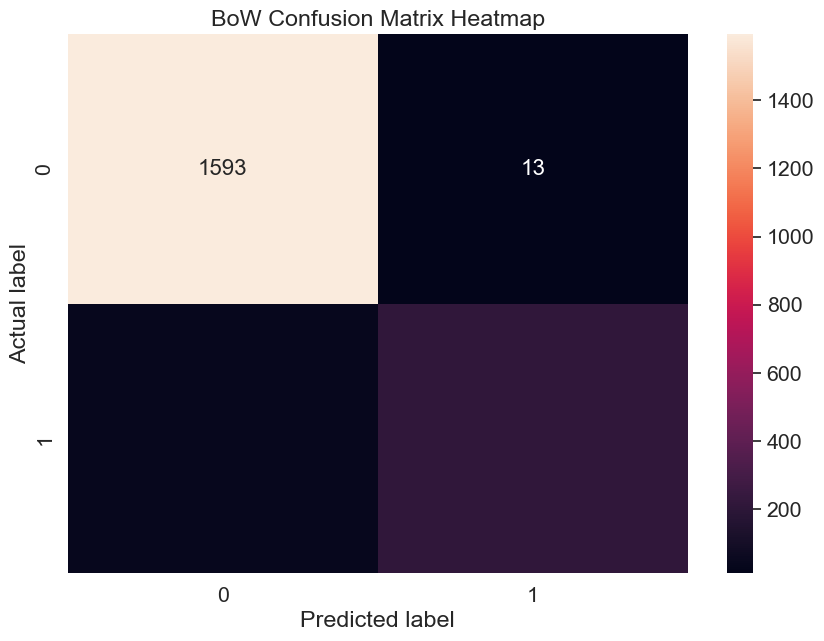

In [171]:
#Accuracy score for bag of words
acc_bow=accuracy_score(test_sentiments, y_pred)
print("ann_bow_score :",acc_bow)

#Classification report for bag of words
bow_report=classification_report(test_sentiments, y_pred,target_names=["Non-Fraudolent","Fraudolent"])
print(bow_report)
# Making the Confusion Matrix
cm_bow = confusion_matrix(test_sentiments, y_pred)
default_conf_matrices["ann_bow"] = cm_bow
f1_scores["ann_bow"] = f1_score(test_sentiments, y_pred)


plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_bow, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('BoW Confusion Matrix Heatmap')
plt.show()


<h5>Training with TF-IDF</h5>

In [172]:
# initializing ANN
classifier = ann_init()

# transforming sparse csr matrix to numpy matrix using todense() function
print(type(tv_train_text))
dense_tv_train_text = tv_train_text.todense()
print(type(dense_tv_train_text))

# Fitting the ANN to the Training set
classifier.fit(dense_tv_train_text, train_sentiments, batch_size = 20, epochs = 5)


<class 'scipy.sparse._csr.csr_matrix'>
<class 'numpy.matrix'>
Epoch 1/5
186/186 [==============================] - 6s 22ms/step - loss: 0.4617 - accuracy: 0.8654
Epoch 2/5
186/186 [==============================] - 4s 24ms/step - loss: 0.1468 - accuracy: 0.8667
Epoch 3/5
186/186 [==============================] - 5s 27ms/step - loss: 0.0940 - accuracy: 0.9645
Epoch 4/5
186/186 [==============================] - 5s 25ms/step - loss: 0.0757 - accuracy: 0.9995
Epoch 5/5
186/186 [==============================] - 4s 22ms/step - loss: 0.0503 - accuracy: 0.9997


<h5>Testing with TF-IDF</h5>

In [173]:
# Predicting the Test set results
dense_tv_test_text = tv_test_text.todense()
y_pred = classifier.predict(dense_tv_test_text)
y_pred = (y_pred > 0.5)


59/59 [==============================] - 1s 6ms/step


ann_tfidf_score : 0.9693218514531755
                precision    recall  f1-score   support

Non-Fraudolent       0.97      1.00      0.98      1606
    Fraudolent       0.98      0.79      0.87       252

      accuracy                           0.97      1858
     macro avg       0.97      0.89      0.93      1858
  weighted avg       0.97      0.97      0.97      1858



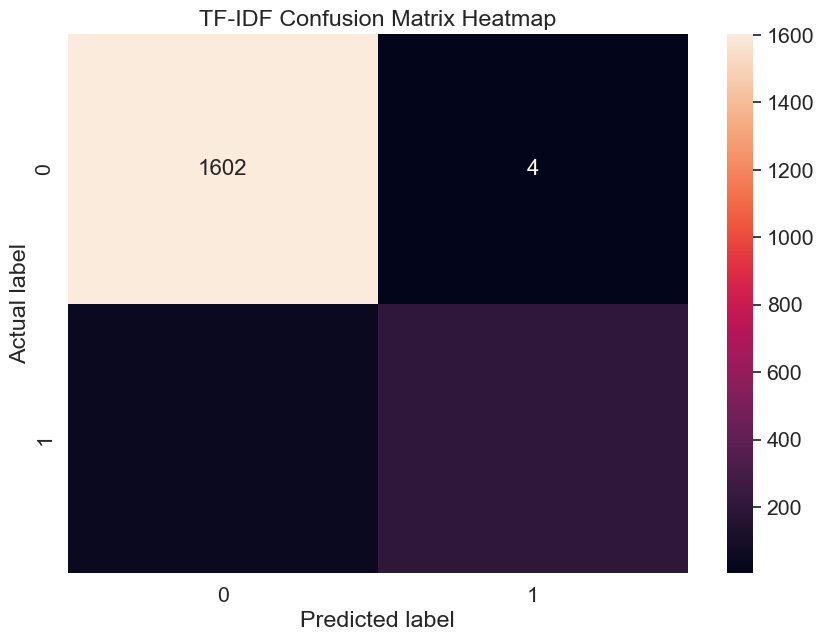

In [174]:
#Accuracy score for bag of words
acc_tfidf=accuracy_score(test_sentiments, y_pred)
print("ann_tfidf_score :",acc_tfidf)

#Classification report for bag of words
tfidf_report=classification_report(test_sentiments, y_pred,target_names=["Non-Fraudolent","Fraudolent"])
print(tfidf_report)

# Making the Confusion Matrix
cm_tfidf = confusion_matrix(test_sentiments, y_pred)
default_conf_matrices["ann_tfidf"] = cm_tfidf
f1_scores["ann_tfidf"] = f1_score(test_sentiments, y_pred)


plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_tfidf, annot=True, annot_kws={"size": 16}, fmt='g')  # fmt='g' is a format option to suppress scientific notation

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('TF-IDF Confusion Matrix Heatmap')
plt.show()


<h2 id="section5">Comparing Testing Results</h2>

<h5>Results from default Parameters. We will plot all of the confusion matrices calculated up this point. </h5>

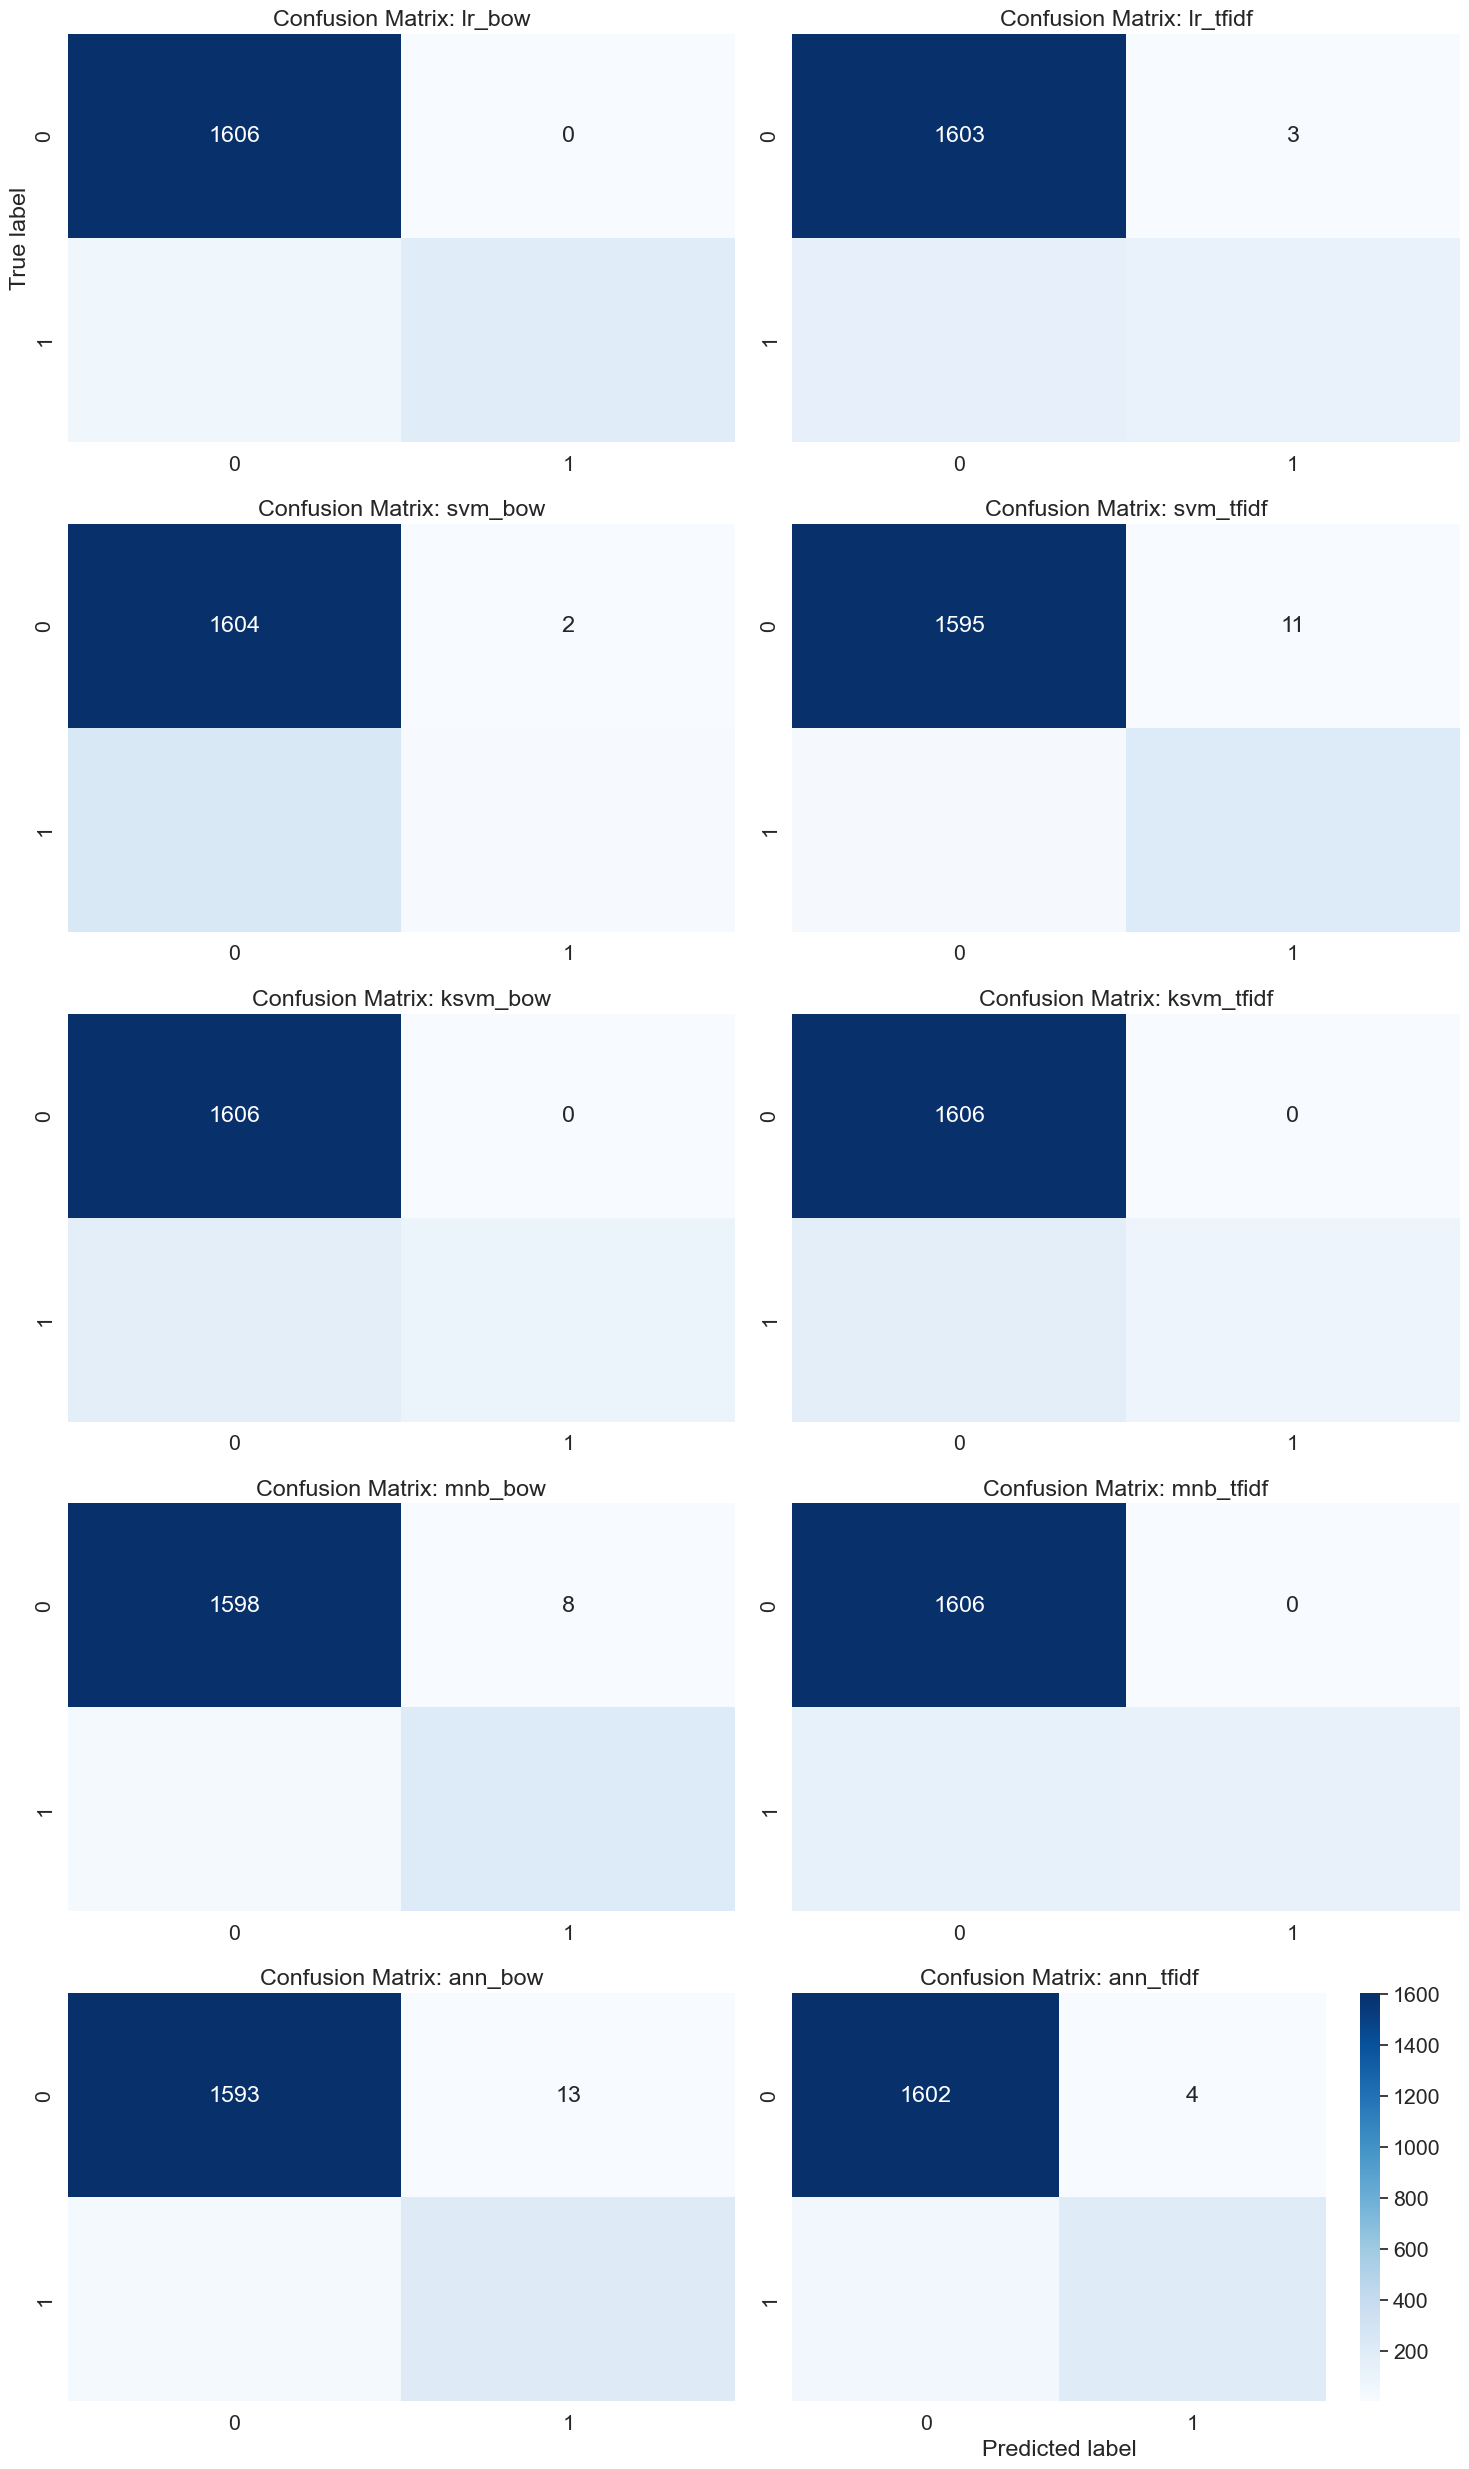

In [175]:
def plot_confusion_matrix(ax, conf_matrix, classifier_name, position):
    sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap='Blues', cbar=(position == 'last'))
    ax.set_title(f'Confusion Matrix: {classifier_name}')
    if position in ['first', 'middle']:
        ax.set_xlabel('')  # Remove x-label
    else:
        ax.set_xlabel('Predicted label')
    if position in ['middle', 'last']:
        ax.set_ylabel('')  # Remove y-label
    else:
        ax.set_ylabel('True label')

# Determine the number of classifiers (and hence, the number of subplots required)
num_classifiers = len(default_conf_matrices)

# Create subplots
fig, axes = plt.subplots(num_classifiers // 2, 2, figsize=(15, 5 * (num_classifiers // 2)))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each confusion matrix
positions = ['first'] + ['middle'] * (num_classifiers - 2) + ['last']
for ax, (classifier_name, conf_matrix), position in zip(axes, default_conf_matrices.items(), positions):
    plot_confusion_matrix(ax, conf_matrix, classifier_name, position)

plt.tight_layout()
plt.show()


<h5>Results after Hyperparameter Tuning. We will plot all of the confusion matrices calculated up this point. </h5>

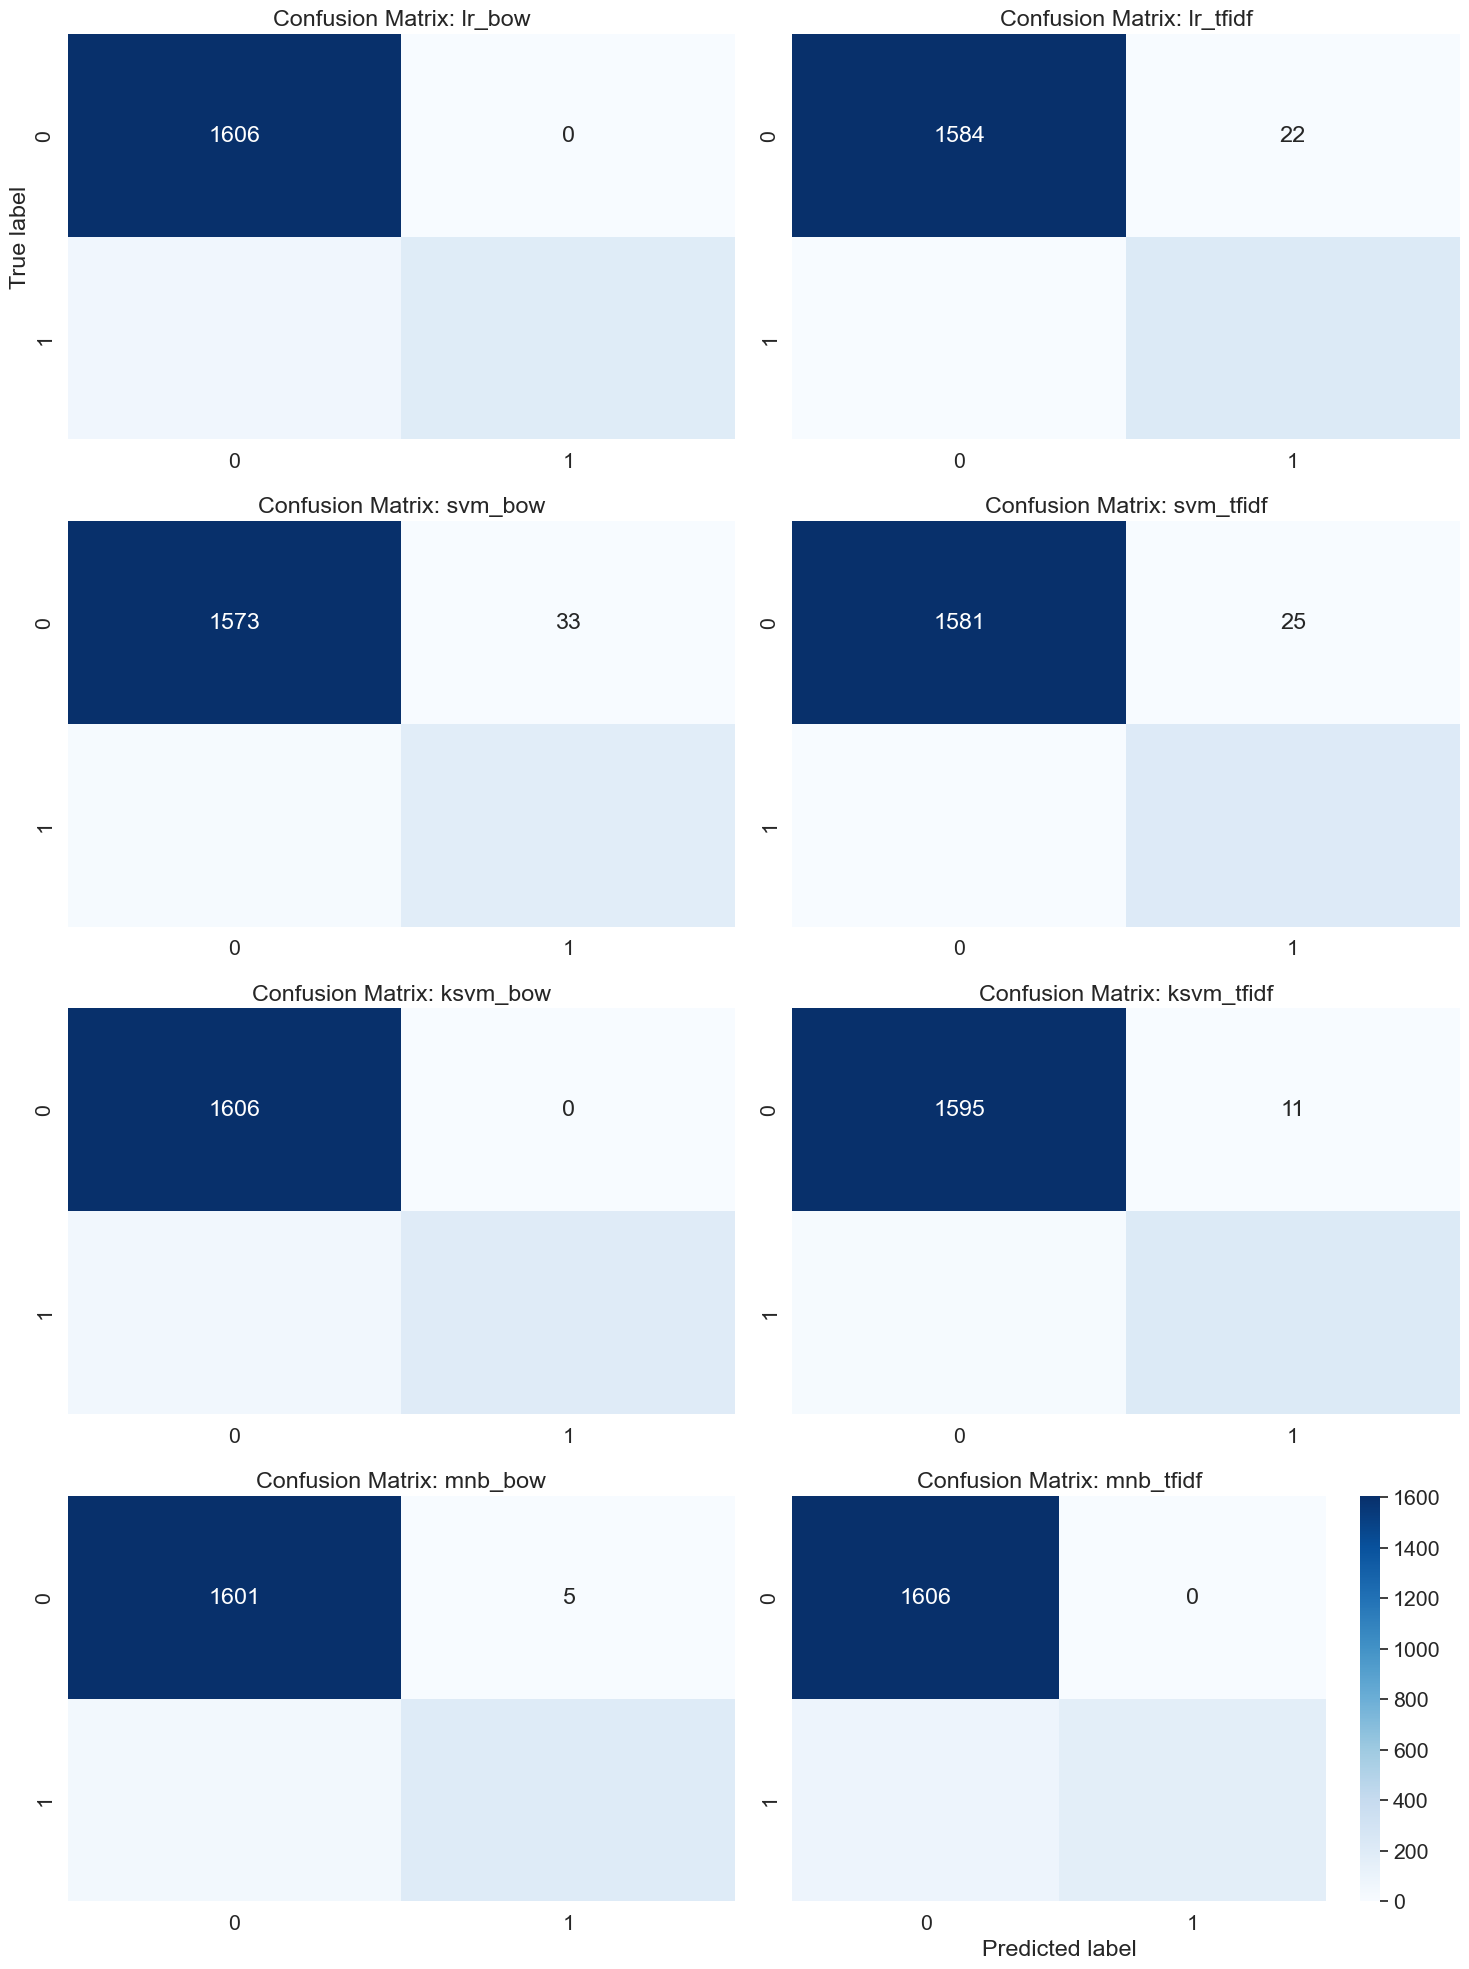

In [176]:
# Determine the number of classifiers (and hence, the number of subplots required)
num_classifiers = len(best_conf_matrices)

# Create subplots
fig, axes = plt.subplots(num_classifiers // 2, 2, figsize=(15, 5 * (num_classifiers // 2)))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each confusion matrix
positions = ['first'] + ['middle'] * (num_classifiers - 2) + ['last']
for ax, (classifier_name, conf_matrix), position in zip(axes, best_conf_matrices.items(), positions):
    plot_confusion_matrix(ax, conf_matrix, classifier_name, position) 

plt.tight_layout()
plt.show()


Now we will print our f1 scores to see which one is the highest.

In [177]:
for key, value in f1_scores.items():
        print(f"{key}: {value}")

lr_bow: 0.8597285067873303
lr_tfidf: 0.9126984126984127
svm_bow: 0.8391038696537678
svm_tfidf: 0.902970297029703
ksvm_bow: 0.8849557522123894
ksvm_tfidf: 0.9221311475409837
mnb_bow: 0.8946236559139784
mnb_tfidf: 0.8
ann_bow: 0.8935281837160752
ann_tfidf: 0.8747252747252747


Finally we can see that the tuned Kernel SVM model gives us the highest F1 score we wanted and for this reason we conclude that for our purpose, this is the best architecture to implement.